#Install import

In [8]:
!pip install geopandas
!pip install geojson
!pip install contextily

In [9]:
import geopandas as gpd
import geojson as gjs
from geopandas import GeoDataFrame
from shapely.geometry import Point, LineString
import pandas as pd
import matplotlib.pyplot as plt
import json
import contextily as ctx
import re

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from pandas import json_normalize
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Bitcarrier Exploration

In [10]:
#Read Bitcarrier csv data Ejemplo
df_bitcarrier = pd.read_csv('/content/drive/My Drive/Team 80 DS4A/Secretaría de Movilidad - SGV/Data ejemplo/Bitcarrier/sep_vel.csv')
display(df_bitcarrier.head())
#Read key file
llave_movilidad = pd.read_excel('/content/drive/My Drive/Team 80 DS4A/Secretaría de Movilidad - SGV/TramosCGT-REV.dbf - original.xlsx')
llave_movilidad.head()

,tid,time,levelofservice,speed,elapsed_time,count,name_from,name_to,distance,type
0,1,2020-09-01 05:00:00,green,35.337000,1781,1,KR7,CL188;CL32,17482,0
1,1000203,2020-09-01 05:03:00,green,58.973682,76,1,KR7,CL188;CL175,1245,1
2,1000201,2020-09-01 05:02:00,green,41.830982,70,1,KR7,CL175;CL170,774,1
3,1000189,2020-09-01 05:02:00,green,32.691700,82,1,KR7,CL170;CL165,673,1
4,1000096,2020-09-01 05:02:00,green,45.033844,86,1,KR7,CL162;CL153,1052,1


,tid,cartodb_id,update_at,name_from,name_to,distance,type,Tipo,Corredor,Sentido,Observación
0,142,142,2020-02-19,AUTONORTE,SANTA.FE;CL80,10680,0,L,Autopista Norte,NS,NaN
1,141,141,2020-02-19,AUTONORTE,CL80;SANTA.FE,10827,0,L,Autopista Norte,SN,NaN
2,36,36,2020-02-19,KR72,CL43AS;CL170,32759,0,L,Av. Boyacá,SN,NaN
3,35,35,2020-02-19,KR72,CL170;CL43AS,32738,0,L,Av. Boyacá,NS,NaN
4,44,44,2020-02-19,CL26,AV.CARACAS;MODELIA,6307,0,L,Av. Calle 26,EW,NaN


In [11]:

print(df_bitcarrier.info())
print(df_bitcarrier.isnull().values.any())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3481291 entries, 0 to 3481290
Data columns (total 10 columns):
 #   Column          Dtype  
---  ------          -----  
 0   tid             int64  
 1   time            object 
 2   levelofservice  object 
 3   speed           float64
 4   elapsed_time    int64  
 5   count           int64  
 6   name_from       object 
 7   name_to         object 
 8   distance        int64  
 9   type            int64  
dtypes: float64(1), int64(5), object(4)
memory usage: 265.6+ MB
None
False


In [12]:
df_bitcarrier['complete_name'] = df_bitcarrier['name_from'] + ' - ' + df_bitcarrier['name_to']

In [13]:
#Asignar nombres corredores del archivo llave al Dataframe de Bitcarrier
df_bitcarrier_mainroad = pd.merge(df_bitcarrier,llave_movilidad, on='tid', how='right')
#df_bitcarrier_mainroad[(df_bitcarrier_mainroad.main_name=='AV.P.MAYO')]
df_bitcarrier_mainroad.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1562434 entries, 0 to 1562433
Data columns (total 21 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   tid             1562434 non-null  int64         
 1   time            1562405 non-null  object        
 2   levelofservice  1562405 non-null  object        
 3   speed           1562405 non-null  float64       
 4   elapsed_time    1562405 non-null  float64       
 5   count           1562405 non-null  float64       
 6   name_from_x     1562405 non-null  object        
 7   name_to_x       1562405 non-null  object        
 8   distance_x      1562405 non-null  float64       
 9   type_x          1562405 non-null  float64       
 10  complete_name   1562405 non-null  object        
 11  cartodb_id      1562434 non-null  int64         
 12  update_at       1562434 non-null  datetime64[ns]
 13  name_from_y     1562434 non-null  object        
 14  name_to_y       15

In [14]:
#Tag and eliminate the main roads in bitcarrier. We have to eliminate because this "segments" have average speed, count of vehicules of all main road. 
#For our analysis this is not good.

b_dict =[{'complete_name':'AUTONORTE - SANTA.FE;CL80', 'complete_road':'yes'},
{'complete_name':'KR72 - CL43AS;CL170', 'complete_road':'yes'},
{'complete_name':'KR72 - CL170;CL43AS', 'complete_road':'yes'},
{'complete_name':'AV.CARACAS - DIAG48SUR;CL80', 'complete_road':'yes'},
{'complete_name':'AV.CARACAS - CL80;DIAG48SUR', 'complete_road':'yes'},
{'complete_name':'KR7 - CL32;CL188', 'complete_road':'yes'},
{'complete_name':'KR7 - CL188;CL32', 'complete_road':'yes'},
{'complete_name':'NQS - CL100;CL59SUR', 'complete_road':'yes'},
{'complete_name':'NQS - CL59SUR;CL100', 'complete_road':'yes'},
{'complete_name':'AV.P.MAYO - KR80;KR3E', 'complete_road':'yes'},
{'complete_name':'AV.P.MAYO - KR3E;KR80', 'complete_road':'yes'},
{'complete_name':'AV.SUBA - KR94;SAN.MARTIN', 'complete_road':'yes'},
{'complete_name':'AV.SUBA - SAN.MARTIN;KR94', 'complete_road':'yes'},
{'complete_name':'CL26 - AV.CARACAS;MODELIA', 'complete_road':'yes'},
{'complete_name':'CL26 - MODELIA;AV.CARACAS', 'complete_road':'yes'},
{'complete_name':'CL80 - AV.CARACAS;KR119', 'complete_road':'yes'},
{'complete_name':'CL80 - KR119;AV.CARACAS', 'complete_road':'yes'},
{'complete_name':'CL13 - KR128;AV.CARACAS', 'complete_road':'yes'},
{'complete_name':'CL13 - AV.CARACAS;KR128', 'complete_road':'yes'},
{'complete_name':'AV.AMERICAS;CL34 - KR80;KR5', 'complete_road':'yes'},
{'complete_name':'KR86 - TV79D;CL90', 'complete_road':'yes'}
]

bit_main_roads = pd.DataFrame.from_dict(b_dict)
bit_main_roads

,complete_name,complete_road
0,AUTONORTE - SANTA.FE;CL80,yes
1,KR72 - CL43AS;CL170,yes
2,KR72 - CL170;CL43AS,yes
3,AV.CARACAS - DIAG48SUR;CL80,yes
4,AV.CARACAS - CL80;DIAG48SUR,yes
5,KR7 - CL32;CL188,yes
6,KR7 - CL188;CL32,yes
7,NQS - CL100;CL59SUR,yes
8,NQS - CL59SUR;CL100,yes
9,AV.P.MAYO - KR80;KR3E,yes


In [15]:
df_bitcarrier_mainroad_2 = df_bitcarrier_mainroad.merge(bit_main_roads, on='complete_name', how='left')
df_bitcarrier_mainroad = df_bitcarrier_mainroad_2[(df_bitcarrier_mainroad_2.complete_road)!='yes']


In [16]:
#Converting time to Date Time type
df_bitcarrier_mainroad['Datetime'] = pd.to_datetime(df_bitcarrier_mainroad['time'])

#Getting Hour and validanting average speed by tid, Hour and level of service
df_bitcarrier_mainroad['hour'] = df_bitcarrier_mainroad['Datetime'].dt.hour
df_bitcarrier_mainroad['day'] = df_bitcarrier_mainroad['Datetime'].dt.day
df_bitcarrier_mainroad['weekday'] = df_bitcarrier_mainroad['Datetime'].dt.weekday

df_bitcarrier_mainroad_weekday = df_bitcarrier_mainroad[(df_bitcarrier_mainroad['weekday']<=4)]
df_bitcarrier_mainroad_weekend = df_bitcarrier_mainroad[(df_bitcarrier_mainroad['weekday']>=5)]

#Group to obtain average speed by Corredor
df_bitcarrier_grouped=df_bitcarrier_mainroad.groupby(['Corredor','complete_name','name_to_x', 'weekday', 'hour','tid', 'Sentido'])['speed'].mean().reset_index()
display(df_bitcarrier_grouped)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

,Corredor,complete_name,name_to_x,weekday,hour,tid,Sentido,speed
0,Autopista Norte,AUTONORTE - ALCALA;CL146,ALCALA;CL146,0.0,0.0,1002018,SN,49.747084
1,Autopista Norte,AUTONORTE - ALCALA;CL146,ALCALA;CL146,0.0,1.0,1002018,SN,52.797171
2,Autopista Norte,AUTONORTE - ALCALA;CL146,ALCALA;CL146,0.0,2.0,1002018,SN,55.806974
3,Autopista Norte,AUTONORTE - ALCALA;CL146,ALCALA;CL146,0.0,3.0,1002018,SN,59.915281
4,Autopista Norte,AUTONORTE - ALCALA;CL146,ALCALA;CL146,0.0,4.0,1002018,SN,60.617092
...,...,...,...,...,...,...,...,...
58209,Av. de las Américas,"AV.AMERICAS,CL34 - KR36;KR28",KR36;KR28,6.0,19.0,1000698,WE,30.710404
58210,Av. de las Américas,"AV.AMERICAS,CL34 - KR36;KR28",KR36;KR28,6.0,20.0,1000698,WE,33.424416
58211,Av. de las Américas,"AV.AMERICAS,CL34 - KR36;KR28",KR36;KR28,6.0,21.0,1000698,WE,32.882612
58212,Av. de las Américas,"AV.AMERICAS,CL34 - KR36;KR28",KR36;KR28,6.0,22.0,1000698,WE,32.562486


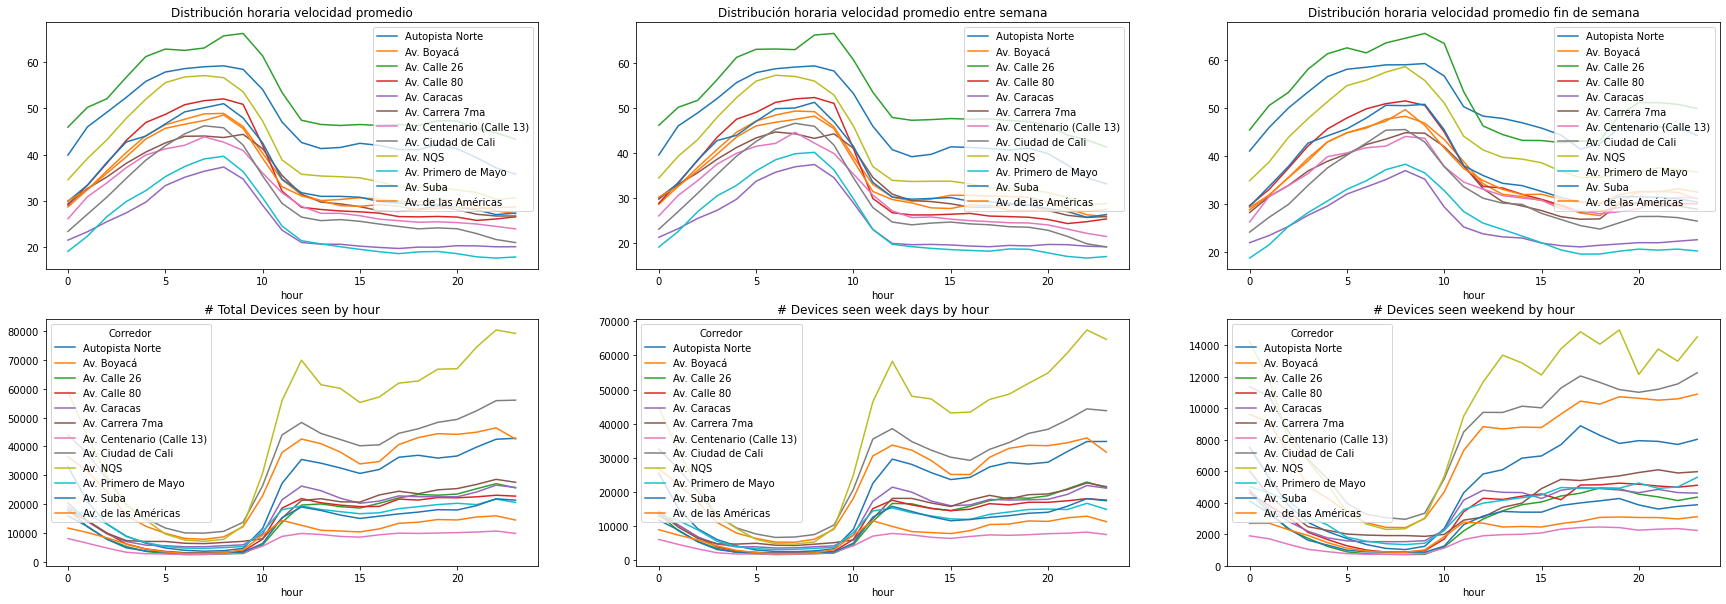

In [17]:
#PLot of average speed by main road by hour.

fig, axes = plt.subplots(2,3, figsize=(30,10))

df_bitcarrier_mainroad.groupby(['hour','Corredor'])['speed'].mean().unstack().plot(ax=axes[0,0], label='Corredor', title="Distribución horaria velocidad promedio").legend()

df_bitcarrier_mainroad_weekday.groupby(['hour','Corredor'])['speed'].mean().unstack().plot(ax=axes[0,1], label='Corredor', title="Distribución horaria velocidad promedio entre semana").legend()

df_bitcarrier_mainroad_weekend.groupby(['hour','Corredor'])['speed'].mean().unstack().plot(ax=axes[0,2], label='Corredor', title="Distribución horaria velocidad promedio fin de semana").legend()

df_bitcarrier_mainroad.groupby(['hour','Corredor'])['count'].sum().unstack().plot(ax=axes[1,0], label='Corredor', title="# Total Devices seen by hour")

df_bitcarrier_mainroad_weekday.groupby(['hour','Corredor'])['count'].sum().unstack().plot(ax=axes[1,1], label='Corredor', title="# Devices seen week days by hour")

df_bitcarrier_mainroad_weekend.groupby(['hour','Corredor'])['count'].sum().unstack().plot(ax=axes[1,2], label='Corredor', title="# Devices seen weekend by hour")

#Esta vista es muy general. Toma la velocidad de promedio de todos los "subtramos" del correor y promedia. Es una primera aproximación al comportamiento de los datos. Se debe ahondar más.

# Review Bitcarrier Shape

In [18]:
#Load bitcarrier shape file
bitcarrier_shp = gpd.read_file('/content/drive/My Drive/Team 80 DS4A/Secretaría de Movilidad - SGV/Data ejemplo/Bitcarrier/TramosCGT.shp')

In [19]:
#Merge shape file with main_roads key file

bitcarrier_merge=bitcarrier_shp.merge(llave_movilidad, on='tid', how='right' )


#print(bitcarrier_merge.info())
#bitcarrier_merge.head(1)

Text(0.5, 1.0, 'Bitcarrier Main roads information - Filtered')

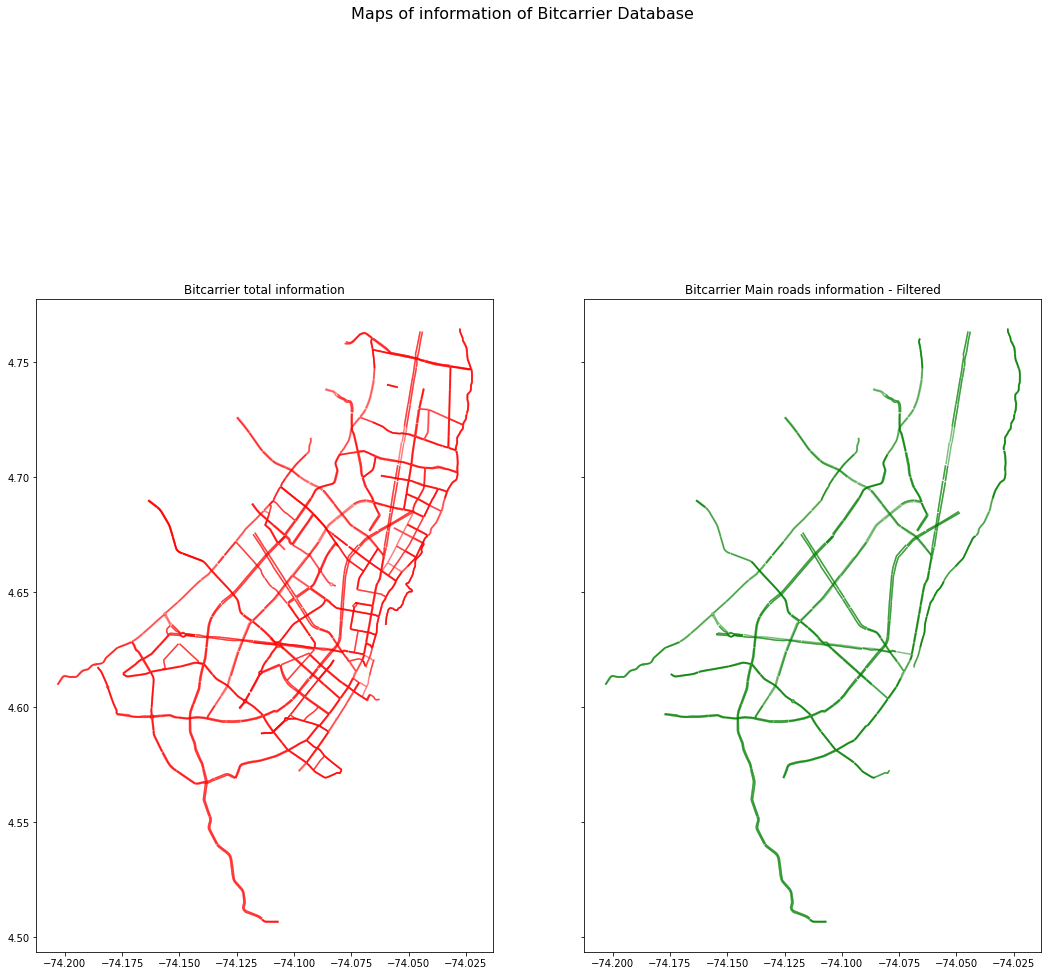

In [20]:
#Mapa de la malla vial basado en el bitcarrier

fig, ax = plt.subplots(1,2, figsize=(18,18), sharey=True)
#Mapa de toda la información del Bitcarrier

bitcarrier_shp.plot(ax=ax[0], alpha=0.5, edgecolor='r')
ax[0].set_title('Bitcarrier total information')
fig.suptitle('Maps of information of Bitcarrier Database', fontsize=16)


#Mapa de los corredores principales
#bitcarrier_merge.apply(lambda x: ax[1].annotate(s=x.Corredor, xy= x.geometry.centroid.coords[0], ha='right', fontsize=8), axis=1)
bitcarrier_merge.plot(ax=ax[1], alpha=0.5, edgecolor='g')
ax[1].set_title('Bitcarrier Main roads information - Filtered')

In [21]:
#Get Geopanda of bitcarrier with geometry of the Corredores and its average speeds
bitcarrier_shp_merged = bitcarrier_merge.merge(df_bitcarrier_grouped, on='tid')
weekday_bd = df_bitcarrier_grouped[(df_bitcarrier_grouped['weekday']<=4)]
weekend_bd = df_bitcarrier_grouped[(df_bitcarrier_grouped['weekday']>4)]

#Weekdays
bitcarrier_shp_weekdays = bitcarrier_merge.merge(weekday_bd, on='tid', how='right')

#Weekend
bitcarrier_shp_weekend = bitcarrier_merge.merge(weekend_bd, on='tid', how='right')



In [22]:
bitcarrier_shp_merged['complete_name']= bitcarrier_shp_merged['Corredor_x'] + " - "  + bitcarrier_shp_merged['name_to_x_x']

Text(0.5, 1.0, 'Bitcarrier weekend information')

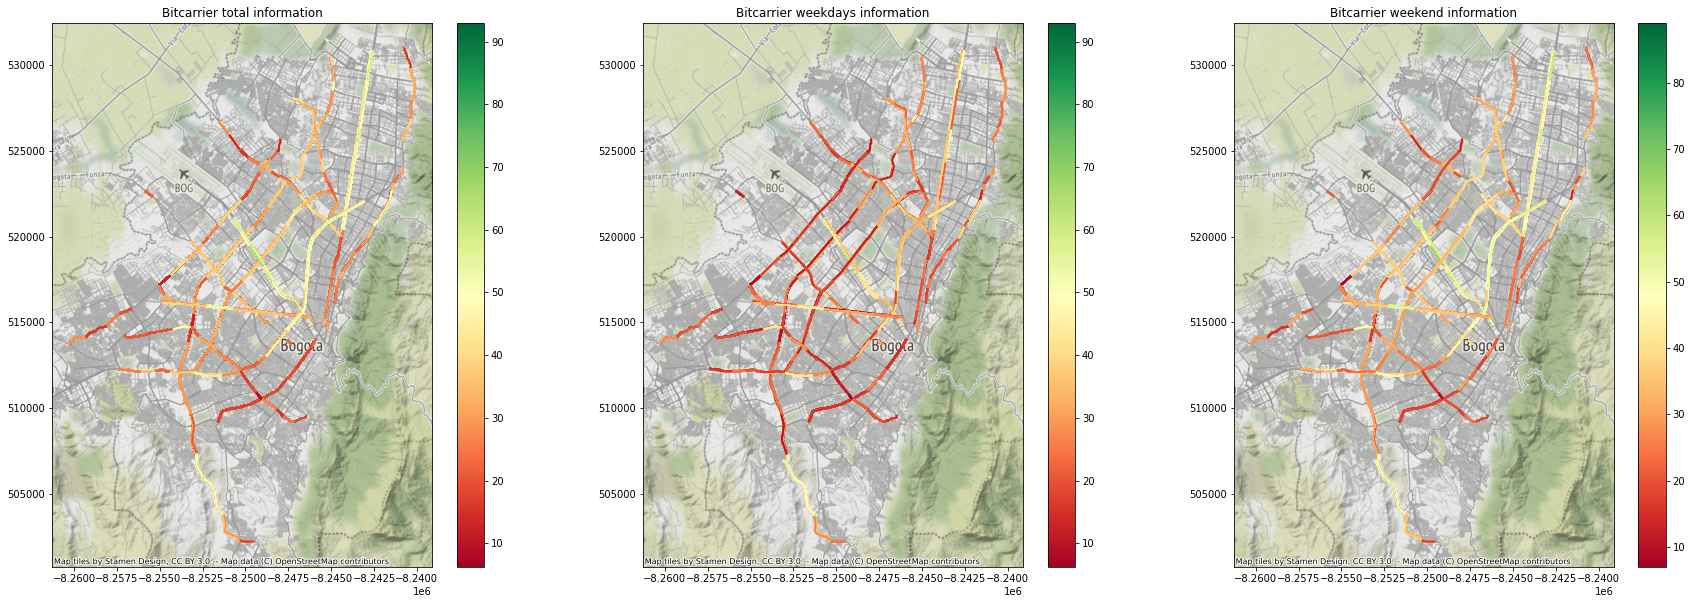

In [23]:
#Map the average speed of corredores
bitcarrier_shp_merged= bitcarrier_shp_merged.to_crs(epsg=3857)
bitcarrier_shp_weekdays= bitcarrier_shp_weekdays.to_crs(epsg=3857)
bitcarrier_shp_weekend= bitcarrier_shp_weekend.to_crs(epsg=3857)


fig, ax = plt.subplots(1,3, figsize=(30,10))
bitcarrier_shp_merged.plot( column='speed', cmap='RdYlGn', ax=ax[0], legend=True)
ctx.add_basemap(ax[0])
ax[0].set_title('Bitcarrier total information')
plt.title('Principales corredores Bogotá - Velocidad promedio todos los días')

bitcarrier_shp_weekdays.plot( column='speed', cmap='RdYlGn', ax=ax[1], legend=True)
ctx.add_basemap(ax[1])
ax[1].set_title('Bitcarrier weekdays information')


bitcarrier_shp_weekend.plot( column='speed', cmap='RdYlGn', ax=ax[2], legend=True)
ctx.add_basemap(ax[2])
ax[2].set_title('Bitcarrier weekend information')

#The Next steps:
# Cómo graficar por hora y por dias para visualizar el cambio?
# Don't use average speed. What is the best measurement for speed?

Text(0.5, 1.0, 'Bitcarrier Av. Caracas')

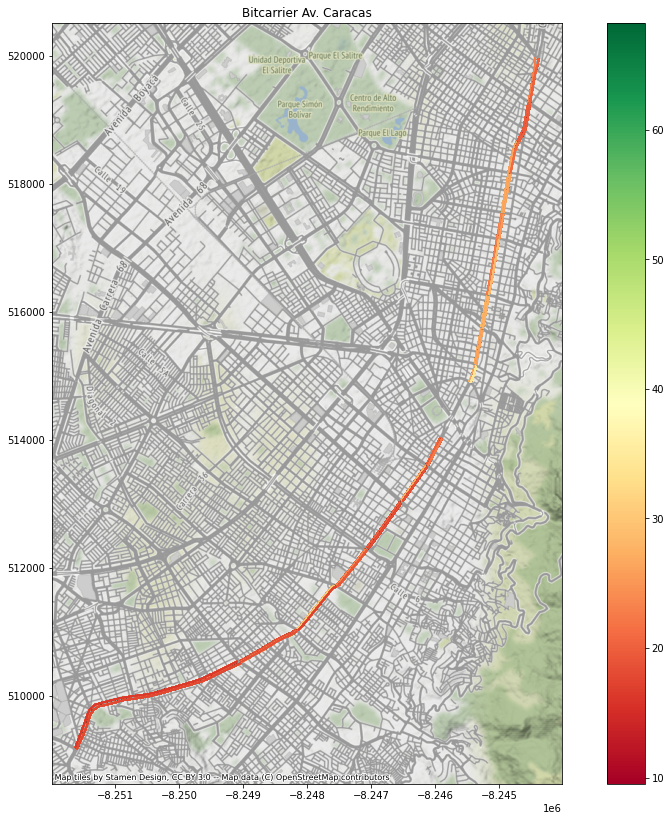

In [24]:
map_corredor = bitcarrier_shp_merged[(bitcarrier_shp_merged.Corredor_x=='Av. Caracas')]

fig, ax = plt.subplots(1, figsize=(16,14))
map_corredor.plot( column='speed', cmap='RdYlGn', ax=ax, legend=True)
ctx.add_basemap(ax)
ax.set_title('Bitcarrier Av. Caracas')


# Waze Speed

In [25]:
#Read waze tramos file AV. AMERICAS
waze_tramos = pd.read_excel('/content/drive/My Drive/Team 80 DS4A/Secretaría de Movilidad - SGV/Vel_Waze_STGV_AVAMERICAS_conllave.xlsx')
waze_tramos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65316 entries, 0 to 65315
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   OBJECTID         65316 non-null  int64         
 1   Id               65316 non-null  int64         
 2   Name             65316 non-null  object        
 3   FromName         65316 non-null  object        
 4   ToName           65316 non-null  object        
 5   Type             65316 non-null  object        
 6   Length           65316 non-null  int64         
 7   JamLevel         65316 non-null  int64         
 8   HistoricTime     65316 non-null  int64         
 9   Time             65316 non-null  int64         
 10  UpdateTimeMilis  65316 non-null  int64         
 11  UpdateTime       65316 non-null  datetime64[ns]
 12  Velocity         65316 non-null  float64       
 13  ReceptionTime    65316 non-null  datetime64[ns]
 14  QuarterHour      65316 non-null  objec

In [26]:
#Define the key to join with bitcarrier
waze_tramos['key_waze'] = waze_tramos['Name'].str.extract(r'\((.*?)\)')

#Het day, weekday
waze_tramos['day'] = waze_tramos['UpdateTime'].dt.day
waze_tramos['weekday'] = waze_tramos['UpdateTime'].dt.weekday

waze_tramos.Id.value_counts()

23202    4740
23203    4738
23204    4737
23205    4737
23206    4737
23207    4736
23237    4101
23238    4101
23239    4100
23240    4100
23241    4099
23242    4099
23244    4097
23245    4097
23246    4097
Name: Id, dtype: int64

In [27]:
waze_tramos[(waze_tramos.Id) == 23202].head()

,OBJECTID,Id,Name,FromName,ToName,Type,Length,JamLevel,HistoricTime,Time,UpdateTimeMilis,UpdateTime,Velocity,ReceptionTime,QuarterHour,Hour,WeekDay,PeakHour,globalid,name_to,letra,Corredor,Sentido,key_waze,day,weekday
0,1,23202,STGV_AVAMERICAS(KR36-KR62)R,Av. de Las Américas > Occidente,Av. de Las Américas > Occidente,STATIC,2963,2,285,501,1591983316127,2020-06-12 17:35:16.127,18.0,2020-06-12 17:36:03.159,30 - 45,12,Friday,NaN,{F701A13C-10EB-4DAD-A434-893C159D4A30},KR36;KR62,R,Av. de las Américas,EW,KR36-KR62,12,4
1,2,23202,STGV_AVAMERICAS(KR36-KR62)R,Av. de Las Américas > Occidente,Av. de Las Américas > Occidente,STATIC,2963,2,284,518,1591983587926,2020-06-12 17:39:47.926,18.0,2020-06-12 17:40:02.858,30 - 45,12,Friday,NaN,{59BE9BCE-8543-486D-9056-FB18C3B535A2},KR36;KR62,R,Av. de las Américas,EW,KR36-KR62,12,4
5,6,23202,STGV_AVAMERICAS(KR36-KR62)R,Av. de Las Américas > Occidente,Av. de Las Américas > Occidente,STATIC,2963,2,285,474,1591983694098,2020-06-12 17:41:34.098,21.6,2020-06-12 17:42:03.132,30 - 45,12,Friday,NaN,{022F92DF-E9CE-411F-85DD-32953E6D3F12},KR36;KR62,R,Av. de las Américas,EW,KR36-KR62,12,4
10,11,23202,STGV_AVAMERICAS(KR36-KR62)R,Av. de Las Américas > Occidente,Av. de Las Américas > Occidente,STATIC,2963,2,285,450,1591983779908,2020-06-12 17:42:59.908,21.6,2020-06-12 17:44:06.946,30 - 45,12,Friday,NaN,{F07CC52C-DE19-400D-9745-27FD073E948A},KR36;KR62,R,Av. de las Américas,EW,KR36-KR62,12,4
17,18,23202,STGV_AVAMERICAS(KR36-KR62)R,Av. de Las Américas > Occidente,Av. de Las Américas > Occidente,STATIC,2963,2,284,448,1591983851812,2020-06-12 17:44:11.812,21.6,2020-06-12 17:46:02.600,30 - 45,12,Friday,NaN,{0A17C1F5-067E-45F7-A66C-FAA4817EB2C1},KR36;KR62,R,Av. de las Américas,EW,KR36-KR62,12,4


In [28]:
#Group waze_tramos to join with bitcarrier grouped

waze_tramos_grouped=waze_tramos.groupby(['Corredor','name_to', 'Sentido',  'weekday', 'Hour'])['Velocity'].mean().reset_index()
waze_tramos_grouped.head()

,Corredor,name_to,Sentido,weekday,Hour,Velocity
0,Av. de las Américas,KR28;KR36,EW,0,0,40.307143
1,Av. de las Américas,KR28;KR36,EW,0,1,38.296552
2,Av. de las Américas,KR28;KR36,EW,0,2,32.466667
3,Av. de las Américas,KR28;KR36,EW,0,3,29.215385
4,Av. de las Américas,KR28;KR36,EW,0,4,29.076923


In [29]:
#Merge bitcarrier with waze, to get the waze speed.

bitcarrier_mainroad_waze = df_bitcarrier_grouped.merge(waze_tramos_grouped, left_on=['name_to_x', 'Sentido', 'weekday', 'hour' ], right_on=['name_to', 'Sentido', 'weekday', 'Hour' ], how='left')

bitcarrier_mainroad_waze.name_to = bitcarrier_mainroad_waze.name_to.astype('category')

bitcarrier_mainroad_waze[(bitcarrier_mainroad_waze.Corredor_x)=='Av. de las Américas'].head()

,Corredor_x,complete_name,name_to_x,weekday,hour,tid,Sentido,speed,Corredor_y,name_to,Hour,Velocity
55527,Av. de las Américas,AV.AMERICAS - KR36;KR62,KR36;KR62,0.0,0.0,1001038,EW,31.688655,Av. de las Américas,KR36;KR62,0.0,39.021429
55528,Av. de las Américas,AV.AMERICAS - KR36;KR62,KR36;KR62,0.0,1.0,1001038,EW,32.745929,Av. de las Américas,KR36;KR62,1.0,37.800000
55529,Av. de las Américas,AV.AMERICAS - KR36;KR62,KR36;KR62,0.0,2.0,1001038,EW,37.488207,Av. de las Américas,KR36;KR62,2.0,34.466667
55530,Av. de las Américas,AV.AMERICAS - KR36;KR62,KR36;KR62,0.0,3.0,1001038,EW,37.709895,Av. de las Américas,KR36;KR62,3.0,30.600000
55531,Av. de las Américas,AV.AMERICAS - KR36;KR62,KR36;KR62,0.0,4.0,1001038,EW,41.884095,Av. de las Américas,KR36;KR62,4.0,30.461538


In [30]:
#Plot bitcarrier vs. Waze speed

df_temp= bitcarrier_mainroad_waze[(bitcarrier_mainroad_waze.Corredor_x)=='Av. de las Américas' ]

fig = px.scatter(df_temp[(df_temp.weekday)<=4 ], x='speed', y='Velocity', color='name_to_x',  facet_col ='hour', facet_col_wrap=4, height =1400, width = 1400, 
                 title='Speed bitcarrier vs. velocity Waze - Weekdays - Av. Americas', hover_data=['weekday'])
fig.show()

# Semáforos

In [31]:
#Get information about traffic lights
semaforos = gpd.read_file('/content/drive/My Drive/Team 80 DS4A/Secretaría de Movilidad - SGV/Data ejemplo/Red semafórica/Red_Semaforica_de_Bogot_conllave/Red_Semaforica_de_Bogot_sincorregir.shp')


In [32]:
display(semaforos.head())
print(semaforos.shape)

,OBJECTID_1,FID_Red_Se,OBJECTID,COD_ID_INT,DIRECCION,LOCALIDAD,TIPO_INTER,INFRA_CICL,OPERACION,FID_Segmen,tid,cartodb_id,update_at,name_from,name_to,distance,type,Tipo,Tipo_1,Corredor,Sentido,Observaci,geometry
0,1,1347,1348,1347,KR 8 X CL 84 SUR,USME,"VEHICULAR, PEATONAL",SIN,NORMAL,12,35,35,2020-02-19,KR72,CL170;CL43AS,32738,0,L,L,Av. Boyacá,NS,None,POINT (-74.10925 4.50661)
1,2,1347,1348,1347,KR 8 X CL 84 SUR,USME,"VEHICULAR, PEATONAL",SIN,NORMAL,16,36,36,2020-02-19,KR72,CL43AS;CL170,32759,0,L,L,Av. Boyacá,SN,None,POINT (-74.10925 4.50661)
2,3,1347,1348,1347,KR 8 X CL 84 SUR,USME,"VEHICULAR, PEATONAL",SIN,NORMAL,60,1002272,1002272,2020-02-19,KR72,KR4aE ;KR1,817,1,None,None,Av. Boyacá,SN,None,POINT (-74.10925 4.50661)
3,4,1347,1348,1347,KR 8 X CL 84 SUR,USME,"VEHICULAR, PEATONAL",SIN,NORMAL,276,1002271,1002271,2020-02-19,KR72,KR1;KR4aE,832,1,None,None,Av. Boyacá,NS,None,POINT (-74.10925 4.50661)
4,5,1211,1212,1459,KR 4E X CL 84 SUR,USME,EXCLUSIVA PEATONAL,SIN,NORMAL,12,35,35,2020-02-19,KR72,CL170;CL43AS,32738,0,L,L,Av. Boyacá,NS,None,POINT (-74.10672 4.50662)


(1449, 23)


In [33]:
semaforos['type'] = semaforos['type'].astype('category')

In [34]:
#We need to see the bitcarrier average speed vs. traffic lights to understand its impact in average

semaforos= semaforos.to_crs(epsg=3857)
fig, ax = plt.subplots(2,2, figsize=(30,30))

#map all days.
bitcarrier_shp_merged.plot( column='speed', cmap='RdYlGn', ax=ax[0,0], legend=True, zorder =1)
semaforos.plot(ax=ax[0,0], column='TIPO_INTER', cmap='tab20b', legend=True, marker ='o', markersize=15, zorder =2)
ctx.add_basemap(ax[0,0])
ax[0,0].set_title('Traffic Lights position with All Bitcarrier information')

#map weekdays
bitcarrier_shp_weekdays.plot( column='speed', cmap='RdYlGn', ax=ax[0,1], legend=True, zorder =1)
semaforos.plot(ax=ax[0,1], column='TIPO_INTER', cmap='tab20b', legend=True, marker ='o', markersize=15, zorder =2)
ctx.add_basemap(ax[0,1])
ax[0,1].set_title('Traffic Lights position with Bitcarrier weekdays information')

#map weekend
bitcarrier_shp_weekend.plot( column='speed', cmap='RdYlGn', ax=ax[1,0], legend=True, zorder =1)
semaforos.plot(ax=ax[1,0], column='TIPO_INTER', cmap='tab20b', legend=True, marker ='o', markersize=15, zorder =2)
ctx.add_basemap(ax[1,0])
ax[1,0].set_title('Traffic Lights position with Bitcarrier weekend information')
plt.title('Main roads average speed with traffic lights by type');

Output hidden; open in https://colab.research.google.com to view.

* We can see an effect in average speed because of traffic lights. 
* Now we can probe this impact.

In [35]:
bitcarrier_shp_merged.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 58214 entries, 0 to 58213
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   tid            58214 non-null  int64         
 1   cartodb_id_x   58214 non-null  int64         
 2   update_at_x    58214 non-null  object        
 3   name_from_x    58214 non-null  object        
 4   name_to_x_x    58214 non-null  object        
 5   distance_x     58214 non-null  int64         
 6   type_x         58214 non-null  int64         
 7   geometry       58214 non-null  geometry      
 8   cartodb_id_y   58214 non-null  int64         
 9   update_at_y    58214 non-null  datetime64[ns]
 10  name_from_y    58214 non-null  object        
 11  name_to_y      58214 non-null  object        
 12  distance_y     58214 non-null  int64         
 13  type_y         58214 non-null  int64         
 14  Tipo           58214 non-null  object        
 15  Corredor_x 

In [36]:

#Merge bitcarrier main roads with traffic lights. The key columns are tid and Sentido.

bitcarrier_trafficlights = df_bitcarrier_mainroad.merge(semaforos, on=['tid','Sentido'])
bitcarrier_shp_trafficlights = bitcarrier_shp_merged.merge(semaforos, left_on=['tid','Sentido_x'],  right_on=['tid','Sentido'])

#bitcarrier_trafficlights.head()

In [37]:
#Count number of traffic lights by bitcarrier segment

bitcarrier_trafficlights_grouped = bitcarrier_trafficlights.groupby(['Corredor_x', 'complete_name', 'Sentido', 'tid']).agg(avg_speed=('speed', 'mean'), count_traffic_lights = ('OBJECTID_1', pd.Series.nunique)).reset_index()

display(bitcarrier_trafficlights_grouped.head(10))

#bitcarrier_trafficlights[bitcarrier_trafficlights.complete_name=='AV.AMERICAS - KR36;KR62']


,Corredor_x,complete_name,Sentido,tid,avg_speed,count_traffic_lights
0,Autopista Norte,AUTONORTE - CL82;CL80,NS,1000036,36.285623,3
1,Autopista Norte,AUTONORTE - VIRREY;CL82,NS,1001993,45.696139,1
2,Av. Boyacá,KR72 - AV.P.MAYO;CL3,SN,1001029,13.349778,2
3,Av. Boyacá,KR72 - AV.P.MAYO;KR69B,NS,1001030,26.943295,1
4,Av. Boyacá,KR72 - CL127;CL134,SN,1000650,36.080476,4
5,Av. Boyacá,KR72 - CL127;CL75,NS,1001016,41.531712,2
6,Av. Boyacá,KR72 - CL12;CL53,SN,1001023,40.096235,1
7,Av. Boyacá,KR72 - CL12;CL9,NS,1001024,40.576179,2
8,Av. Boyacá,KR72 - CL134;CL127,NS,1000649,37.763944,4
9,Av. Boyacá,KR72 - CL134;CL138,SN,1000648,35.324232,2


In [38]:

#Scatter plot by corredor all bitcarrier information
fig = px.scatter(bitcarrier_trafficlights_grouped, x='avg_speed', y='count_traffic_lights', facet_col ='Corredor_x', facet_col_wrap=3, color='Sentido', 
                 hover_data=['Corredor_x', 'complete_name', 'Sentido', 'tid'], title='Average Speed vs. # Traffic Lights by all Bitcarrier information', height = 1000, width = 1400)

fig.show()

In [39]:
#Count number of traffic lights by bitcarrier segment weekdays and weekend

bitcarrier_trafficlights_weekday = bitcarrier_trafficlights[(bitcarrier_trafficlights['weekday']<=4)]
bitcarrier_trafficlights_weekend = bitcarrier_trafficlights[(bitcarrier_trafficlights['weekday']>=5)]


bitcarrier_trafficlights_weekday_grouped = bitcarrier_trafficlights_weekday.groupby(['Corredor_x', 'complete_name', 'Sentido', 'tid']).agg(avg_speed=('speed', 'mean'), count_traffic_lights = ('OBJECTID_1', pd.Series.nunique)).reset_index()
bitcarrier_trafficlights_weekend_grouped = bitcarrier_trafficlights_weekend.groupby(['Corredor_x', 'complete_name', 'Sentido', 'tid']).agg(avg_speed=('speed', 'mean'), count_traffic_lights = ('OBJECTID_1', pd.Series.nunique)).reset_index()


#display(bitcarrier_trafficlights_weekday_grouped.head(10))

In [40]:
#Scatter plot by corredor weekdays bitcarrier information
fig = px.scatter(bitcarrier_trafficlights_weekday_grouped , x='avg_speed', y='count_traffic_lights', facet_col ='Corredor_x', facet_col_wrap=3, color='Sentido', 
                 hover_data=['Corredor_x', 'complete_name', 'Sentido', 'tid'], title='Average Speed vs. # Traffic Lights by weekdays Bitcarrier information', height = 1000, width = 1400)

#fig = px.scatter(bitcarrier_trafficlights_weekday_grouped[(bitcarrier_trafficlights_weekday_grouped.Corredor_x)=='Av. Carrera 7ma'] , x='avg_speed', y='count_traffic_lights', facet_col ='Corredor_x', facet_col_wrap=3, color='Sentido', 
#                 hover_data=['Corredor_x', 'complete_name', 'Sentido', 'tid'], title='Average Speed vs. # Traffic Lights by weekdays Bitcarrier information', height = 1000, width = 1400)


fig.show()

In [41]:
#Correlation
print('Correlation average speed vs. # traffic lights weekdays')
print()
print('All main roads: ' + str(round(bitcarrier_trafficlights_weekday_grouped.avg_speed.corr(bitcarrier_trafficlights_weekday_grouped.count_traffic_lights),4)))
print()
print('1. Autopista Norte: ' + str(round(bitcarrier_trafficlights_weekday_grouped[(bitcarrier_trafficlights_weekday_grouped.Corredor_x)=='Autopista Norte'].avg_speed.corr(bitcarrier_trafficlights_weekday_grouped[(bitcarrier_trafficlights_weekday_grouped.Corredor_x)=='Autopista Norte'].count_traffic_lights),4)))
print('2. Av. Boyacá: ' + str(round(bitcarrier_trafficlights_weekday_grouped[(bitcarrier_trafficlights_weekday_grouped.Corredor_x)=='Av. Boyacá'].avg_speed.corr(bitcarrier_trafficlights_weekday_grouped[(bitcarrier_trafficlights_weekday_grouped.Corredor_x)=='Av. Boyacá'].count_traffic_lights),4)))
print('3. Av. Caracas: ' + str(round(bitcarrier_trafficlights_weekday_grouped[(bitcarrier_trafficlights_weekday_grouped.Corredor_x)=='Av. Caracas'].avg_speed.corr(bitcarrier_trafficlights_weekday_grouped[(bitcarrier_trafficlights_weekday_grouped.Corredor_x)=='Av. Caracas'].count_traffic_lights),4)))
print('4. Av. Carrera 7ma: ' + str(round(bitcarrier_trafficlights_weekday_grouped[(bitcarrier_trafficlights_weekday_grouped.Corredor_x)=='Av. Carrera 7ma'].avg_speed.corr(bitcarrier_trafficlights_weekday_grouped[(bitcarrier_trafficlights_weekday_grouped.Corredor_x)=='Av. Carrera 7ma'].count_traffic_lights),4)))
print('5. Av. Ciudad de Cali: ' + str(round(bitcarrier_trafficlights_weekday_grouped[(bitcarrier_trafficlights_weekday_grouped.Corredor_x)=='Av. Ciudad de Cali'].avg_speed.corr(bitcarrier_trafficlights_weekday_grouped[(bitcarrier_trafficlights_weekday_grouped.Corredor_x)=='Av. Ciudad de Cali'].count_traffic_lights),4)))
print('6. Av. NQS: ' + str(round(bitcarrier_trafficlights_weekday_grouped[(bitcarrier_trafficlights_weekday_grouped.Corredor_x)=='Av. NQS'].avg_speed.corr(bitcarrier_trafficlights_weekday_grouped[(bitcarrier_trafficlights_weekday_grouped.Corredor_x)=='Av. NQS'].count_traffic_lights),4)))
print('7. Av. Primero de Mayo: ' + str(round(bitcarrier_trafficlights_weekday_grouped[(bitcarrier_trafficlights_weekday_grouped.Corredor_x)=='Av. Primero de Mayo'].avg_speed.corr(bitcarrier_trafficlights_weekday_grouped[(bitcarrier_trafficlights_weekday_grouped.Corredor_x)=='Av. Primero de Mayo'].count_traffic_lights),4)))
print('8. Av. Suba: ' + str(round(bitcarrier_trafficlights_weekday_grouped[(bitcarrier_trafficlights_weekday_grouped.Corredor_x)=='Av. Suba'].avg_speed.corr(bitcarrier_trafficlights_weekday_grouped[(bitcarrier_trafficlights_weekday_grouped.Corredor_x)=='Av. Suba'].count_traffic_lights),4)))
print('9. Av. Calle 26: ' + str(round(bitcarrier_trafficlights_weekday_grouped[(bitcarrier_trafficlights_weekday_grouped.Corredor_x)=='Av. Calle 26'].avg_speed.corr(bitcarrier_trafficlights_weekday_grouped[(bitcarrier_trafficlights_weekday_grouped.Corredor_x)=='Av. Calle 26'].count_traffic_lights),4)))
print('10. Av. Calle 80: ' + str(round(bitcarrier_trafficlights_weekday_grouped[(bitcarrier_trafficlights_weekday_grouped.Corredor_x)=='Av. Calle 80'].avg_speed.corr(bitcarrier_trafficlights_weekday_grouped[(bitcarrier_trafficlights_weekday_grouped.Corredor_x)=='Av. Calle 80'].count_traffic_lights),4)))
print('11. Av. Centenario (Calle 13): ' + str(round(bitcarrier_trafficlights_weekday_grouped[(bitcarrier_trafficlights_weekday_grouped.Corredor_x)=='Av. Centenario (Calle 13)'].avg_speed.corr(bitcarrier_trafficlights_weekday_grouped[(bitcarrier_trafficlights_weekday_grouped.Corredor_x)=='Av. Centenario (Calle 13)'].count_traffic_lights),4)))
print('12. Av. de las Américas: ' + str(round(bitcarrier_trafficlights_weekday_grouped[(bitcarrier_trafficlights_weekday_grouped.Corredor_x)=='Av. de las Américas'].avg_speed.corr(bitcarrier_trafficlights_weekday_grouped[(bitcarrier_trafficlights_weekday_grouped.Corredor_x)=='Av. de las Américas'].count_traffic_lights),4)))


Correlation average speed vs. # traffic lights weekdays

All main roads: -0.337

1. Autopista Norte: -1.0
2. Av. Boyacá: -0.0386
3. Av. Caracas: -0.3746
4. Av. Carrera 7ma: -0.6017
5. Av. Ciudad de Cali: -0.1132
6. Av. NQS: -0.6956
7. Av. Primero de Mayo: 0.03
8. Av. Suba: -0.3893
9. Av. Calle 26: -0.6675
10. Av. Calle 80: 0.384
11. Av. Centenario (Calle 13): -0.1713
12. Av. de las Américas: -0.3429


In [42]:
#Scatter plot by corredor weekend bitcarrier information
fig = px.scatter(bitcarrier_trafficlights_weekend_grouped , x='avg_speed', y='count_traffic_lights', facet_col ='Corredor_x', facet_col_wrap=3, color='Sentido', 
                 hover_data=['Corredor_x', 'complete_name', 'Sentido', 'tid'], title='Average Speed vs. # Traffic Lights by weekends Bitcarrier information', height = 1000, width = 1400)

fig.show()